In [1]:
# basics
import os, glob, sys, datetime, pathlib
from tempfile import NamedTemporaryFile, TemporaryDirectory
from subprocess import run, PIPE
from getpass import getuser
import numpy as np
import xarray as xr
import pandas as pd

# map projections
import cartopy.crs as crs
from pyproj import Transformer, transform
#transformer = Transformer.from_crs(4326, "ESRI:54009")

# Plots
import datashader as ds
#from datashader.mpl_ext import dsshow
import matplotlib
import matplotlib.pyplot as plt

# more colormaps
import cmocean
import seaborn as sns

# dask
import multiprocessing
import dask
from dask.distributed import Client, progress
dask.config.config.get('distributed').get('dashboard').update({'link':'{JUPYTERHUB_SERVICE_PREFIX}/proxy/{port}/status'})

# Warnings
import warnings
warnings.filterwarnings(action='ignore')

/home/m/m300948/.conda/envs/JUPYTER_MODULE/lib/python3.9/site-packages/datashader/transfer_functions.py:21: FutureWarning: xarray subclass Image should explicitly define __slots__
  class Image(xr.DataArray):


In [2]:
import Tools

In [38]:
# !convert -resize 60% -delay 20 -loop 0 ts_*.png trial_ts.gif to make movie from gif

In [4]:
#PlotNative

In [5]:
#PlotLonLat
def plot_lonlat(ax, data_xr, date_plot, coastlines=True, projection=None, cmap=cmocean.cm.thermal, levels=None):
    if levels is None:
        levels = np.linspace(np.round(data_xr.min().values, 0), np.round(data_xr.max().values, 0), 11)
    coastlines = ax.coastlines(resolution='110m',linewidth=0.6) if coastlines else None
    if transform is None:
        draw = data_xr.plot(ax=ax, cmap=cmap, levels = levels, extend='max', add_colorbar=False)
    else:
        draw = data_xr.plot(ax=ax, transform=projection, cmap=cmap, levels = levels, extend='max', add_colorbar=False)
    colobar = plt.colorbar(draw, orientation='horizontal', pad=0.06, shrink=0.5, extend='max', label='Temperature [K]')
    return ax

# Dask

In [3]:
client = Tools.dask_starter(nworker_min=16, nworker_max=16, memory='256GB')
client

Number of CPUs: 256, number of threads: 16, number of workers: 16


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/m300948/levante-spawner-preset//proxy/8787/status,
Dashboard: /user/m300948/levante-spawner-preset//proxy/8787/status,Workers: 1
Total threads: 16,Total memory: 5.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:44543,Workers: 1
Dashboard: /user/m300948/levante-spawner-preset//proxy/8787/status,Total threads: 16
Started: Just now,Total memory: 5.00 GiB
Comm: tcp://127.0.0.1:38567,Total threads: 16
Dashboard: /user/m300948/levante-spawner-preset//proxy/42383/status,Memory: 5.00 GiB
Nanny: tcp://127.0.0.1:46491,


# Input Data

In [4]:
path_input_ctl = pathlib.Path('/work/mh0731/m300948/nextgems_cycle2_2/experiments/TEST02/work')
path_input_def = pathlib.Path('/work/mh0731/m300948/nextgems_cycle2_2/experiments/DEF100/work')
path_land_fraction = pathlib.Path('/pool/data/ICON/grids/public/mpim/0015-0016/land/r0005_fast/bc_land_frac_2015.nc') #R2B09
remap_grid_description = pathlib.Path('/work/mh0287/m300901/tropic_power/bash_scripts/lonlat_025_60W_20E.txt')

In [8]:
# ERA5 Data - Daily Avg 60W-20E 20S-20N
era5_2d_list = []
era5_variable = []
for f in (path_era5).glob(f'ERA5_*'):
    variable = str(f)[str(f).rfind("ERA5_")+5:str(f).rfind(".nc")]
    if variable in ['pr', 'temp_2m', 'sst']:
        era5_2d_list.append(str(f))
        era5_variable.append(variable)
#era5_2d_list = sorted(era5_2d_list)

In [6]:
# ctl Data - 30min inst 2D-Data 60W-20E 20S-20N
ctl_2d_list = []
files = sorted([str(f) for f in path_input_ctl.glob(f'run_2020*/*atm_2d_ml*')],reverse=True)[:]

for f in files:
    if str(f)[-19:-3] not in [str(t)[-19:-3] for t in ctl_2d_list]:
#if str(f)[-19:-3] for f in files not in str(t)[-19:-3] for t in ctl_2d_list:
        #print(str(f)[-19:-3])
        ctl_2d_list.append(str(f))
        
ctl_2d_list = sorted(ctl_2d_list)

In [9]:
# NGC2002 Data - 30min inst 2D-Data 60W-20E 20S-20N
ngc2002_2d_list = []
for f in (path_input_ngc).glob(f'run*/*atm_2d_ml*'):
    if str(f)[99:101] in ['03', '04', '05']:
        ngc2002_2d_list.append(str(f))
ngc2002_2d_list = sorted(ngc2002_2d_list)

### Get Data sets

In [10]:
# ERA5
data_era5 = xr.Dataset()
for i in range(len(era5_variable)):
    era5, _ = Tools.get_data(era5_2d_list[i], path_grid=None, chunk='auto')
    era5 = era5.rename({list(era5.keys())[0]: era5_variable[i]})
    data_era5 = xr.merge((data_era5, era5))
data_era5 = data_era5.chunk({'time':1, 'lon':320, 'lat':320})

In [11]:
data_era5;

In [ ]:
data_native_ctl, grid_ctl = Tools.get_data(ctl_2d_list[:], native_grid=True, chunk={"ncells": 5 * 4 ** 10, "time": 1})
#land_with_mask, grid_mask = Tools.get_land_mask(data_native_ngc, grid_ngc, path_land_fraction)

In [ ]:
data_native_ctl

In [15]:
data_native_ngc, grid_ngc = Tools.get_data(ngc2002_2d_list[:], native_grid=True, chunk={"ncells": 5 * 4 ** 10, "time": 1})
#land_with_mask, grid_mask = Tools.get_land_mask(data_native_ngc, grid_ngc, path_land_fraction)

In [16]:
data_native_ngc

<xarray.Dataset>
Dimensions:        (time: 3574, ncells: 20971520, height: 1, height_2: 1, nv: 3)
Coordinates:
  * height         (height) float64 10.0
  * height_2       (height_2) float64 2.0
  * time           (time) datetime64[ns] 2020-03-01 ... 2020-05-14T10:30:00
    clon           (ncells) float64 1.274 1.275 1.273 ... 1.335 1.336 1.334
    clat           (ncells) float64 0.9182 0.9185 0.9185 ... -0.7894 -0.7895
    clon_vertices  (ncells, nv) float64 1.274 1.273 1.275 ... 1.335 1.334 1.334
    clat_vertices  (ncells, nv) float64 0.9189 0.9178 0.9178 ... -0.7899 -0.7888
Dimensions without coordinates: ncells, nv
Data variables: (12/37)
    ps             (time, ncells) float32 dask.array<chunksize=(1, 5242880), meta=np.ndarray>
    psl            (time, ncells) float32 dask.array<chunksize=(1, 5242880), meta=np.ndarray>
    rsdt           (time, ncells) float32 dask.array<chunksize=(1, 5242880), meta=np.ndarray>
    rsut           (time, ncells) float32 dask.array<chunksize=(1, 5242880), meta=np.ndarray>
    rsutcs         (time, ncells) float32 dask.array<chunksize=(1, 5242880), meta=np.ndarray>
    rlut           (time, ncells) float32 dask.array<chunksize=(1, 5242880), meta=np.ndarray>
    ...             ...
    tauu           (time, ncells) float32 dask.array<chunksize=(1, 5242880), meta=np.ndarray>
    tauv           (time, ncells) float32 dask.array<chunksize=(1, 5242880), meta=np.ndarray>
    sfcwind        (time, height, ncells) float32 dask.array<chunksize=(1, 1, 5242880), meta=np.ndarray>
    uas            (time, height, ncells) float32 dask.array<chunksize=(1, 1, 5242880), meta=np.ndarray>
    vas            (time, height, ncells) float32 dask.array<chunksize=(1, 1, 5242880), meta=np.ndarray>
    tas            (time, height_2, ncells) float32 dask.array<chunksize=(1, 1, 5242880), meta=np.ndarray>
Attributes:
    CDI:                  Climate Data Interface version 1.8.3rc (http://mpim...
    Conventions:          CF-1.6
    number_of_grid_used:  15
    grid_file_uri:        http://icon-downloads.mpimet.mpg.de/grids/public/mp...
    uuidOfHGrid:          0f1e7d66-637e-11e8-913b-51232bb4d8f9
    institution:          Max Planck Institute for Meteorology/Deutscher Wett...
    title:                ICON simulation
    source:               git@gitlab.dkrz.de:icon/icon-aes.git@db0c65ef52e144...
    history:              ./icon at 20220407 035947
    references:           see MPIM/DWD publications
    comment:              Sapphire Dyamond (k203123) on l40436 (Linux 4.18.0-...

### Select Area of interest

In [17]:
# Select Box
box_native_ngc, grid_cut = Tools.get_info_native(data_native_ngc, grid_ngc, ['ts', ], lon_range=[-60, 20], lat_range=[-20, 20], interest='all')

In [18]:
box_native_ngc

<xarray.Dataset>
Dimensions:        (time: 3574, ncells: 1577984, nv: 3)
Coordinates:
    clon_vertices  (ncells, nv) float64 -1.047 -1.047 -1.048 ... -1.047 -1.048
    clat_vertices  (ncells, nv) float64 0.109 0.11 0.1101 ... -0.1958 -0.1947
  * time           (time) datetime64[ns] 2020-03-01 ... 2020-05-14T10:30:00
    clon           (ncells) float64 -1.047 -1.047 -1.047 ... -1.046 -1.047
    clat           (ncells) float64 0.1097 0.1086 0.1083 ... -0.194 -0.1951
Dimensions without coordinates: ncells, nv
Data variables:
    ts             (time, ncells) float32 dask.array<chunksize=(1, 788992), meta=np.ndarray>
Attributes:
    CDI:                  Climate Data Interface version 1.8.3rc (http://mpim...
    Conventions:          CF-1.6
    number_of_grid_used:  15
    grid_file_uri:        http://icon-downloads.mpimet.mpg.de/grids/public/mp...
    uuidOfHGrid:          0f1e7d66-637e-11e8-913b-51232bb4d8f9
    institution:          Max Planck Institute for Meteorology/Deutscher Wett...
    title:                ICON simulation
    source:               git@gitlab.dkrz.de:icon/icon-aes.git@db0c65ef52e144...
    history:              ./icon at 20220407 035947
    references:           see MPIM/DWD publications
    comment:              Sapphire Dyamond (k203123) on l40436 (Linux 4.18.0-...

In [19]:
# Make daily averages
data_ngc = Tools.run_in_dask(client, box_native_ngc, box_native_ngc.resample(time='1d').mean('time'))

In [20]:
data_ngc

<xarray.Dataset>
Dimensions:        (time: 75, ncells: 1577984, nv: 3)
Coordinates:
  * time           (time) datetime64[ns] 2020-03-01 2020-03-02 ... 2020-05-14
    clon_vertices  (ncells, nv) float64 -1.047 -1.047 -1.048 ... -1.047 -1.048
    clat_vertices  (ncells, nv) float64 0.109 0.11 0.1101 ... -0.1958 -0.1947
    clon           (ncells) float64 -1.047 -1.047 -1.047 ... -1.046 -1.047
    clat           (ncells) float64 0.1097 0.1086 0.1083 ... -0.194 -0.1951
Dimensions without coordinates: ncells, nv
Data variables:
    ts             (time, ncells) float32 295.6 295.3 295.2 ... 293.7 294.1

In [19]:
data_ngc_remapped = Tools.remapcon_native(client, data_ngc, remap_grid_description)

In [79]:
data_ngc_remapped;

# Work

In [28]:
ngc_ds = data_ngc_remapped.isel(time=slice(0,75))
era5_ds = data_era5.isel(time=slice(0,75)).assign_coords(time=ngc_ds.time)

### Daily snapshots

In [29]:
for time_step in range(len(era5_ds.time.values)):
    example_era5 = era5_ds.temp_2m.isel(time=time_step)
    example_ngc = ngc_ds.ts.isel(time=time_step)
    date_plot = np.datetime_as_string(example_era5.time.values, unit='D')
    levels = np.linspace(280,310,11)
    # To Plot
    Tools.control_freak(0.75)
    fig = plt.figure(figsize=(24, 5), facecolor='white')
    gs = fig.add_gridspec(1,3)
    # ERA5
    ax = fig.add_subplot(gs[0, 0], projection=crs.PlateCarree())
    plot_lonlat(ax, example_era5, date_plot, coastlines=True, projection=crs.PlateCarree(), cmap=cmocean.cm.thermal, levels=levels)
    ax.set_title(f'Surface Temperature ERA5 - Date: {date_plot}')
    # NGC2002
    ax = fig.add_subplot(gs[0, 1], projection=crs.PlateCarree())
    plot_lonlat(ax, example_ngc, date_plot, coastlines=True, projection=crs.PlateCarree(), cmap=cmocean.cm.thermal, levels=levels)
    ax.set_title(f'Surface Temperature NGC2002 - Date: {date_plot}')
    # Diff(ERA5-NGC2002)
    ax = fig.add_subplot(gs[0, 2], projection=crs.PlateCarree())
    plot_lonlat(ax, example_ngc - example_era5, date_plot, coastlines=True, projection=crs.PlateCarree(), 
                cmap=sns.color_palette("vlag", as_cmap=True), levels=np.linspace(-5,5,11))
    ax.set_title(f'Surface Temperature NGC2002 vs ERA5 - Date: {date_plot}');
    plt.savefig(f'plots/ts_{str(time_step).zfill(3)}.png', dpi=90, bbox_inches='tight', facecolor=fig.get_facecolor());
    plt.close();

### Hovmoller Diagram

In [30]:
hov_native_ngc, grid_cut = Tools.get_info_native(land_with_mask, grid_mask, ['ts', ], lon_range=[-60, 20], lat_range=[-5, 5], interest='all')

In [34]:
hov_native_daily_ngc = hov_native_ngc.resample(time='1d').mean('time')
operation = Tools.hist_mean(hov_native_daily_ngc['ts'], bins=320, source_coord='clon', target_dim='lon', hist_range=np.deg2rad([-60, 20]))

In [35]:
hovmuller_ngc = Tools.run_in_dask(client, hov_native_daily_ngc, operation)

2022-09-13 12:17:22,591 - bokeh.core.property.validation - ERROR - 'truediv-849405641bd5d7aaf0e20588db211145'
Traceback (most recent call last):
  File "/sw/spack-levante/mambaforge-4.11.0-0-Linux-x86_64-sobz6z/lib/python3.9/site-packages/distributed/utils.py", line 767, in wrapper
    return func(*args, **kwargs)
  File "/sw/spack-levante/mambaforge-4.11.0-0-Linux-x86_64-sobz6z/lib/python3.9/site-packages/distributed/dashboard/components/scheduler.py", line 2432, in update_layout
    order = dask.order.order(
  File "/sw/spack-levante/mambaforge-4.11.0-0-Linux-x86_64-sobz6z/lib/python3.9/site-packages/dask/order.py", line 117, in order
    metrics = graph_metrics(dependencies, dependents, total_dependencies)
  File "/sw/spack-levante/mambaforge-4.11.0-0-Linux-x86_64-sobz6z/lib/python3.9/site-packages/dask/order.py", line 888, in graph_metrics
    val = total_dependencies[key]
KeyError: 'truediv-849405641bd5d7aaf0e20588db211145'
2022-09-13 12:17:22,957 - bokeh.util.tornado - ERROR - Er

In [36]:
hovmuller_ngc['lon'] = np.rad2deg(hovmuller_ngc['lon'].values)

In [43]:
hovmuller_era5 = Tools.run_in_dask(client, data_era5, data_era5.temp_2m.sel(lat=slice(-5,5)).mean('lat'))

In [70]:
ngc_ds = hovmuller_ngc.ts.isel(time=slice(0,75))
era5_ds = hovmuller_era5.isel(time=slice(0,75)).assign_coords(time=ngc_ds.time).assign_coords(lon=ngc_ds.lon)

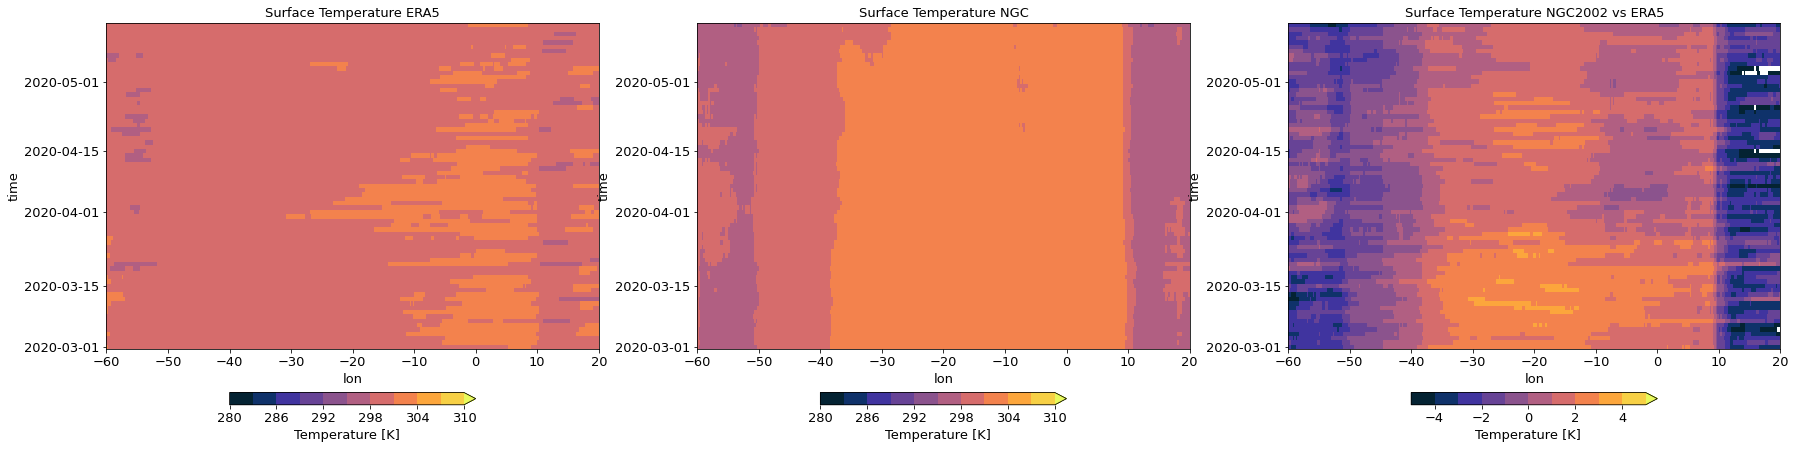

In [72]:
Tools.control_freak(0.65)
fig = plt.figure(figsize=(30, 8), facecolor='white')
gs = fig.add_gridspec(1,3)
levels = np.linspace(280,310,11)
# ERA5
ax = fig.add_subplot(gs[0, 0])
draw = era5_ds.plot(ax=ax, cmap=cmocean.cm.thermal, levels=levels, extend='max', add_colorbar=False)
colobar = plt.colorbar(draw, orientation='horizontal', pad=0.1, shrink=0.5, extend='max', label='Temperature [K]')
ax.set_title(f'Surface Temperature ERA5')
# ngc2002
ax = fig.add_subplot(gs[0, 1])
draw = ngc_ds.plot(ax=ax, cmap=cmocean.cm.thermal, levels=levels, extend='max', add_colorbar=False)
colobar = plt.colorbar(draw, orientation='horizontal', pad=0.1, shrink=0.5, extend='max', label='Temperature [K]')
ax.set_title(f'Surface Temperature NGC')
# Diff(ERA5-NGC2002)
levels = np.linspace(-5,5,11)
ax = fig.add_subplot(gs[0, 2])
draw = (ngc_ds - era5_ds).plot(ax=ax, cmap=cmocean.cm.thermal, levels=levels, extend='max', add_colorbar=False)
colobar = plt.colorbar(draw, orientation='horizontal', pad=0.1, shrink=0.5, extend='max', label='Temperature [K]')
ax.set_title(f'Surface Temperature NGC2002 vs ERA5');
plt.savefig(f'plots/ts_hovmuller.png', dpi=90, bbox_inches='tight', facecolor=fig.get_facecolor());
#plt.close();

In [85]:
!squeue --me

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
           1970936   compute aqua_07_  m300901  R    3:43:44      1 l40278
           1970937   compute aqua_07_  m300901  R    3:43:44      1 l40279
           1970938   compute aqua_07_  m300901  R    3:43:44      1 l40280
           1970939   compute aqua_07_  m300901  R    3:43:44      1 l40281
           1970940   compute aqua_07_  m300901  R    3:43:44      1 l40282
           1970941   compute aqua_07_  m300901  R    3:43:44      1 l40283
           1970942   compute aqua_07_  m300901  R    3:43:44      1 l40287
           1970943   compute aqua_07_  m300901  R    3:43:44      1 l40288
           1968737   compute spawner-  m300901  R    6:07:47      1 l20211


In [88]:
13577.984523606 / 60

226.2997420601